In [35]:
from qaoa import *
import matplotlib.pyplot as plt
# Set a random seed for reproducibility
np.random.seed(42)

In [36]:
# Example 1: Creating an Ising Hamiltonian and Finding Fisher Information Matrix

# Define the number of qubits and connectivity type ("open" or "closed")
n_qubits = 4
connectivity = "closed"

# Create an Ising Hamiltonian
ising_hamiltonian = H_zz_Ising(n_qubits, connectivity)

depth = 1
# Initialize QAOA with a specific depth and the Ising Hamiltonian
qaoa = QAOA(depth=depth, H=ising_hamiltonian)

# Define a set of parameters
angles = [0.5, 0.2]*depth  # Adjust these parameters as needed

# Calculate the Fisher Information Matrix
qfi_matrix = qaoa.qaoa_qfi_matrix(angles, state_ini=plus_state(n_qubits)) #|+>

print("Fisher Information Matrix:")
with np.printoptions(precision=3, suppress=True):
    print(qfi_matrix)


Fisher Information Matrix:
[[16.     0.   ]
 [ 0.    29.273]]


In [37]:
# Example 2: Creating a k-SAT Hamiltonian and Optimizing it with QAOA

# Define the number of variables (n), clauses (k), and alpha for k-SAT Hamiltonian
n = 5
k = 3
alpha = 2.0

# Create a k-SAT Hamiltonian
k_sat_hamiltonian = H_sat(n, k, alpha)

depth = 2
# Initialize QAOA with a specific depth and the k-SAT Hamiltonian
qaoa = QAOA(depth=depth, H=k_sat_hamiltonian)


# Run the QAOA optimization using the L-BFGS-B method
qaoa.run()

# Print the optimization results
with np.printoptions(precision=3, suppress=True):
    print("QAOA Parameters:", qaoa.opt_angles)
    print("Optimized QAOA Energy:", qaoa.q_energy)


QAOA Parameters: [1.261 3.682 1.142 1.765]
Optimized QAOA Energy: 0.5039655121265381


In [38]:
# Example 3: Solving the Max Cut Problem

# Define the graph adjacency matrix (replace this with your specific graph)
graph = [
    [0, 1, 1, 0],
    [1, 0, 0, 1],
    [1, 0, 0, 1],
    [0, 1, 1, 0]
]

# Number of qubits, which is the same as the number of nodes in the graph will be calculated inside the function
# Convert the graph into the corresponding Ising Hamiltonian
max_cut_hamiltonian = Graph_to_Hamiltonian(graph)

depth = 4
# Now you can use your QAOA solver to find the maximum cut
qaoa = QAOA(depth=depth, H=max_cut_hamiltonian)
qaoa.run()

# Extract the results
max_cut_solution = qaoa.f_state  # The quantum state
max_cut_value = qaoa.q_energy  # The value of the maximum cut

# Output the results
with np.printoptions(precision=3, suppress=True):
    print("Max Cut Solution (quantum state):\n", max_cut_solution)
    print("Max Cut Value:", max_cut_value)

Max Cut Solution (quantum state):
 [ 0.   +0.j    -0.   +0.j    -0.   +0.j     0.   -0.j    -0.   +0.j
  0.   -0.j    -0.507+0.493j -0.   +0.j    -0.   +0.j    -0.507+0.493j
  0.   -0.j    -0.   +0.j     0.   -0.j    -0.   +0.j    -0.   +0.j
  0.   +0.j   ]
Max Cut Value: -3.999999999998185


In [39]:
# Example 4: Calculate the Average Expectation with Noise

# Define the number of qubits and connectivity type ("open" or "closed")
n_qubits = 4
connectivity = "closed"

# Define the depth of the QAOA circuit
depth = 2

# Create an Ising Hamiltonian
ising_hamiltonian = H_zz_Ising(n_qubits, connectivity)

# Initialize QAOA with a specific depth and the Ising Hamiltonian
qaoa = QAOA(depth=depth, H=ising_hamiltonian)


# Find optimum angles
qaoa = QAOA(depth=depth, H=ising_hamiltonian)
qaoa.run()
angles = qaoa.opt_angles  # Adjust these parameters as needed

# Create Kraus operators and probabilities for the depolarization channel
p_depolarization = 0.01  # Adjust the depolarization probability
depolarization_kraus_ops, depolarization_probabilities = create_depolarization_kraus(p_depolarization)


# Apply the QAOA ansatz with depolarization noise
state_with_noise = qaoa.expectation_noise(angles, noise_prob=depolarization_probabilities, kraus_ops=depolarization_kraus_ops,num_samples=100)

# Print the state vector with depolarization noise
print("Average Expectation with Depolarization Noise:",state_with_noise)
print("Expectation without Noise:", qaoa.expectation(angles))

Average Expectation with Depolarization Noise: 0.03352151037420148
Expectation without Noise: 2.942091015256665e-15


Time to perform the regular L-BFGS-B method:  0.05013847351074219
Time to perform the natural gradient strategy:  0.04353785514831543
Time to perform the layer-wise learning:  0.4973621368408203


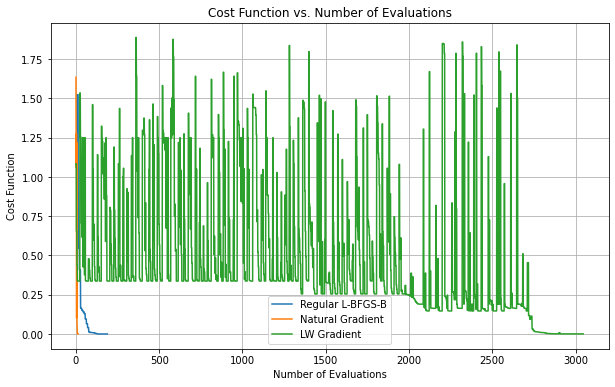

In [46]:
# Example 5.1: Compare optimization strategies
# The crucial part is not only the found minimum but also the number of evaluations required 
np.random.seed(25)
# Define the number of variables (n), clauses (k), and alpha for k-SAT Hamiltonian
n = 5
k = 2
alpha = 1.0

# Create a k-SAT Hamiltonian
k_sat_hamiltonian = H_sat(n, k, alpha)

depth = 3
# Initialize QAOA with a specific depth and the k-SAT Hamiltonian
qaoa = QAOA(depth=depth, H=k_sat_hamiltonian)
qaoa.track_cost = True
# Run optimization using the regular L-BFGS-B method
qaoa.run()
cost_values_reg = np.copy(qaoa.tracked_cost)
qaoa.tracked_cost = []
print('Time to perform the regular L-BFGS-B method: ', qaoa.exe_time)
# Run optimization using the natural gradient strategy
qaoa.run_QFI()
cost_values_natgrad = np.copy(qaoa.tracked_cost)
qaoa.tracked_cost = []
print('Time to perform the natural gradient strategy: ', qaoa.exe_time)
# Run optimization using the layer-wise learning
qaoa.run_heuristic_LW()
cost_values_lw = np.copy(qaoa.tracked_cost)
qaoa.tracked_cost = []
print('Time to perform the layer-wise learning: ', qaoa.exe_time)
# Plot the cost function vs. number of evaluations
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(cost_values_reg)), cost_values_reg, label='Regular L-BFGS-B')
plt.plot(np.arange(len(cost_values_natgrad)), cost_values_natgrad, label='Natural Gradient')
plt.plot(np.arange(len(cost_values_lw)), cost_values_lw, label='LW Gradient')
plt.xlabel('Number of Evaluations')
plt.ylabel('Cost Function')
plt.title('Cost Function vs. Number of Evaluations')
plt.legend()
plt.grid(True)
plt.show()

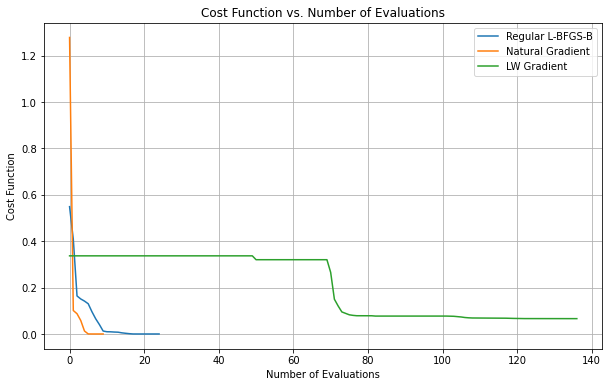

In [45]:
# Example 5.2: Compare optimization strategies
np.random.seed(25)
# Define the number of variables (n), clauses (k), and alpha for k-SAT Hamiltonian
n = 5
k = 2
alpha = 1.0

# Create a k-SAT Hamiltonian
k_sat_hamiltonian = H_sat(n, k, alpha)

depth = 3
# Initialize QAOA with a specific depth and the k-SAT Hamiltonian
qaoa = QAOA(depth=depth, H=k_sat_hamiltonian)

# Run optimization using the regular L-BFGS-B method
opt_angles_reg, q_energy_reg, cost_values_reg = qaoa.run_with_tracking()

# Run optimization using the natural gradient strategy
opt_angles_natgrad, q_energy_natgrad, cost_values_natgrad = qaoa.run_QFI_with_tracking()

# Run optimization using the layer-wise learning
opt_angles_lw, q_energy_lw, cost_values_lw = qaoa.run_heuristic_LW_with_tracking()

# Plot the cost function vs. number of evaluations
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(cost_values_reg)), cost_values_reg, label='Regular L-BFGS-B')
plt.plot(np.arange(len(cost_values_natgrad)), cost_values_natgrad, label='Natural Gradient')
plt.plot(np.arange(len(cost_values_lw)), cost_values_lw, label='LW Gradient')
plt.xlabel('Number of Evaluations')
plt.ylabel('Cost Function')
plt.title('Cost Function vs. Number of Evaluations')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
qaoa.eval_num

3390